In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import time

2025-05-01 15:15:27.073636: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-01 15:15:27.073687: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-01 15:15:27.074494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 15:15:27.080432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"


In [9]:
from tensorflow import keras
import numpy as np

# 设置目标分类组合
target_labels = [3, 5]  # 可修改为 [4,9] 或 [2,7] 等

# 加载 MNIST 数据
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# 筛选标签为 target_labels 的图像
train_mask = np.isin(train_labels, target_labels)
test_mask = np.isin(test_labels, target_labels)

train_images = train_images[train_mask]
train_labels = train_labels[train_mask]
test_images = test_images[test_mask]
test_labels = test_labels[test_mask]

# 将标签映射为 0 和 1（便于交叉熵计算）
train_labels = (train_labels == target_labels[1]).astype(np.int32)
test_labels = (test_labels == target_labels[1]).astype(np.int32)

# 按类平衡选择样本数（可调）
def select_balanced_subset(images, labels, per_class_train, per_class_test):
    selected_train_images, selected_train_labels = [], []
    selected_test_images, selected_test_labels = [], []

    for label_val in [0, 1]:
        train_idx = np.where(labels == label_val)[0][:per_class_train]
        test_idx = np.where(test_labels == label_val)[0][:per_class_test]
        selected_train_images.append(images[train_idx])
        selected_train_labels.append(labels[train_idx])
        selected_test_images.append(test_images[test_idx])
        selected_test_labels.append(test_labels[test_idx])

    train_images_final = np.concatenate(selected_train_images, axis=0)
    train_labels_final = np.concatenate(selected_train_labels, axis=0)
    test_images_final = np.concatenate(selected_test_images, axis=0)
    test_labels_final = np.concatenate(selected_test_labels, axis=0)

    return train_images_final, train_labels_final, test_images_final, test_labels_final

# 设置样本数（建议）
train_images, train_labels, test_images, test_labels = select_balanced_subset(
    train_images, train_labels, per_class_train=50, per_class_test=15
)

# 归一化 & 添加通道维度
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

print("Train:", train_images.shape, train_labels.shape)
print("Test :", test_images.shape, test_labels.shape)


Train: (100, 28, 28, 1) (100,)
Test : (30, 28, 28, 1) (30,)


In [10]:

class Quanvolutional_Layer():

  def __init__(self,size_filter,layers_filter,stride_filter,padding):
    self.size_filter   = size_filter         # Determines the number of qubits to be required for the random cicuit (2-4)[time increases NP hard]
    self.layers_filter = layers_filter       # Number of random circuits since each filter is a realization of a circuit
    self.stride_filter = stride_filter       # Stride same meaning as classical counterpart
    self.padding       = padding             # Experimental feature ***Not Implemented***

    # Circuit design i.e. number of qubits required for encoding
    self.dev           = qml.device("default.qubit", wires=self.size_filter*self.size_filter)

    # Along each circuit we require (filter_size)^2 parameters randomly initialized
    self.rand_params   = np.random.uniform(high=2 * np.pi, size=(self.layers_filter, (self.size_filter*self.size_filter)))
    print("Created Basic Properties")


  # The qfilter generted will have the following gate properties :
  # 1) Encoding  : Ry rotation gate where the angles are scaled by PI
  # 2) Ciruit    : Of n_layers random in nature
  # 3) Decoding  : 4 expectation value measurements
  # decorator for quantum node
  def creator(self,phi):
    # Due the decorator access we specified a function inside another function

    @qml.qnode(self.dev)
    def circuit(phi):
      # List containg all qubit outputs
      op_list = []

      # Encoding on each of the filter value along each wire
      for j in range(self.size_filter*self.size_filter):
        qml.RY(np.pi * phi[j], wires=j) # BloC sphere mapping

      # Random quantum circuit generation based on the random paramters we chose
      # The first dimension of rand_params (adjusts the number of layers we care about they are weights)
      # Iterating one filter at a time
      for k in self.rand_params:
        tmp = np.expand_dims(k,axis=0) # convert into 1 layer, number of qubits
        RandomLayers(tmp, wires=list(range(self.size_filter*self.size_filter)))
        for j in range(self.size_filter*self.size_filter):
          op_list.append(qml.expval(qml.PauliZ(j)))
      return op_list

    # op_list of shape : number of filters, number of qubits
    op_list = circuit(phi)
    op_list = np.array(op_list)
    return list(np.reshape(op_list, (self.layers_filter, (self.size_filter*self.size_filter))))

  def call(self,image):

    # Sanity check wether the paramters specified is alright for the image dimensions
    calc = math.floor((image.shape[1]+2*self.padding-self.size_filter)/self.stride_filter) + 1
    if calc <1:
      return -1
    # Stide reductions along the height and width dim & filter size = number of filters * number of qubits
    out = np.zeros((calc,calc,self.layers_filter*(self.size_filter*self.size_filter)))
    print(image.shape)
    print(out.shape)
    

    # Output collection array
    collection = []
    index = 0
    for i in image:
      out = np.zeros((calc,calc,self.layers_filter*(self.size_filter*self.size_filter)))
      # Progress checker
      print("Image processed :",index+1)
      # Stride based steps
      for j in range(0, i.shape[0], self.stride_filter):
        for k in range(0, i.shape[1], self.stride_filter):
          phi = []
          # Padding not yet implemented
          if(j+self.size_filter > i.shape[0]) | (k+self.size_filter > i.shape[1]):
            continue
          for l in range(j,j+self.size_filter): 
            for m in range(k,k+self.size_filter):
              phi.append(i[l][m][0])
              
          q_results = self.creator(phi)
          
          ctr = 0
          for x in q_results:
            for y in range(len(x)):
              out[j//self.stride_filter, k//self.stride_filter,ctr] = x[y]
              ctr+=1
      collection.append(out) 
      index+=1
    return collection


In [29]:

Quan2D = Quanvolutional_Layer(2,1,2,0)
op_train = Quan2D.call(train_images)
op_train = np.asarray(op_train, dtype=np.float32)

op_test  = Quan2D.call(test_images)
op_test  = np.asarray(op_test, dtype=np.float32)

     

Created Basic Properties
(100, 28, 28, 1)
(14, 14, 4)
Image processed : 1
Image processed : 2
Image processed : 3
Image processed : 4
Image processed : 5
Image processed : 6
Image processed : 7
Image processed : 8
Image processed : 9
Image processed : 10
Image processed : 11
Image processed : 12
Image processed : 13
Image processed : 14
Image processed : 15
Image processed : 16
Image processed : 17
Image processed : 18
Image processed : 19
Image processed : 20
Image processed : 21
Image processed : 22
Image processed : 23
Image processed : 24
Image processed : 25
Image processed : 26
Image processed : 27
Image processed : 28
Image processed : 29
Image processed : 30
Image processed : 31
Image processed : 32
Image processed : 33
Image processed : 34
Image processed : 35
Image processed : 36
Image processed : 37
Image processed : 38
Image processed : 39
Image processed : 40
Image processed : 41
Image processed : 42
Image processed : 43
Image processed : 44
Image processed : 45
Image proc

In [30]:
print(op_train.shape)
print(op_test.shape)
print(op_train[0])

(100, 14, 14, 4)
(30, 14, 14, 4)
[[[ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]]

 [[ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0.10606591 -0.8346166 ]
  [ 1.         -0.8346166  -0

In [69]:
np.save('MNIST_op_train.npy', op_train)
np.save('MNIST_op_test.npy', op_test)

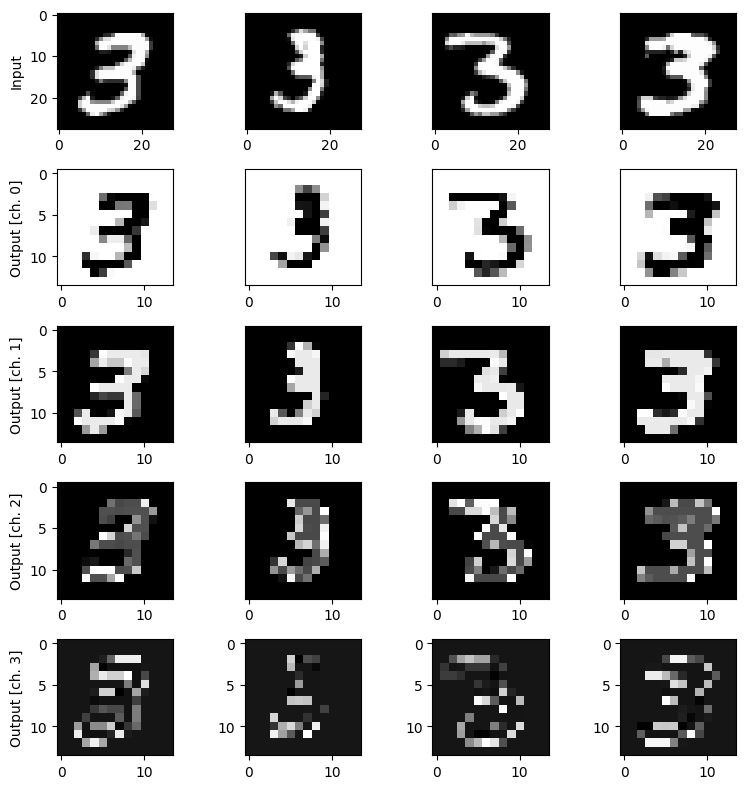

In [31]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(8, 8))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(op_train[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [33]:
def MyModel():
    model = keras.models.Sequential([
            keras.layers.Flatten(),
            keras.layers.Dense(10, activation="softmax")
    ])
    
    model.compile(
            optimizer=keras.optimizers.SGD(learning_rate=lr),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
    )
    return model

In [41]:
n_epochs = 100   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 100    # Size of the train dataset
n_test = 30     # Size of the test dataset
lr = 0.001
# SAVE_PATH = "/home/chris/QCNN/Quanvolutional_network/Quantum_images/" # Data saving folder
# PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [42]:
q_model = MyModel()
q_history = q_model.fit( op_train,
                     train_labels,
                     validation_data=(op_test, test_labels),
                     batch_size=4,
                     epochs=n_epochs,
                     verbose=2,)

Epoch 1/100
25/25 - 0s - loss: 1.4908 - accuracy: 0.4700 - val_loss: 1.0806 - val_accuracy: 0.5000 - 394ms/epoch - 16ms/step
Epoch 2/100
25/25 - 0s - loss: 0.8146 - accuracy: 0.6700 - val_loss: 0.8987 - val_accuracy: 0.5333 - 71ms/epoch - 3ms/step
Epoch 3/100
25/25 - 0s - loss: 0.6649 - accuracy: 0.7300 - val_loss: 0.8140 - val_accuracy: 0.6000 - 72ms/epoch - 3ms/step
Epoch 4/100
25/25 - 0s - loss: 0.5927 - accuracy: 0.7800 - val_loss: 0.7614 - val_accuracy: 0.6000 - 68ms/epoch - 3ms/step
Epoch 5/100
25/25 - 0s - loss: 0.5424 - accuracy: 0.7900 - val_loss: 0.7261 - val_accuracy: 0.6000 - 69ms/epoch - 3ms/step
Epoch 6/100
25/25 - 0s - loss: 0.5027 - accuracy: 0.7800 - val_loss: 0.6793 - val_accuracy: 0.6333 - 72ms/epoch - 3ms/step
Epoch 7/100
25/25 - 0s - loss: 0.4692 - accuracy: 0.8200 - val_loss: 0.6621 - val_accuracy: 0.6333 - 70ms/epoch - 3ms/step
Epoch 8/100
25/25 - 0s - loss: 0.4368 - accuracy: 0.8000 - val_loss: 0.6808 - val_accuracy: 0.6667 - 70ms/epoch - 3ms/step
Epoch 9/100
25

In [160]:
# 获取 accuracy 和 loss 历史
val_accuracies = q_history.history['val_accuracy']
val_losses = q_history.history['val_loss']

print("Validation Accuracy:")
for acc in val_accuracies:
    print(f"{acc:.4f}")

print("\nValidation Loss:")
for loss in val_losses:
    print(f"{loss:.4f}")

Validation Accuracy:
0.5000
0.5333
0.6000
0.6000
0.6000
0.6333
0.6333
0.6667
0.6333
0.7000
0.6667
0.7000
0.7000
0.7333
0.7000
0.7333
0.7333
0.7667
0.7333
0.7333
0.7333
0.7333
0.7333
0.7667
0.7333
0.7667
0.7667
0.8000
0.8000
0.8000
0.8000
0.7667
0.8000
0.7667
0.8000
0.8000
0.8000
0.8000
0.7667
0.7667
0.7667
0.8000
0.8000
0.8000
0.8000
0.8000
0.8333
0.8000
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8000
0.8000
0.8333
0.8333
0.8000
0.8333
0.8333
0.8000
0.8000
0.8333
0.8000
0.8000
0.8000
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8667
0.8667
0.8667
0.8333
0.8000

Validation Loss:
1.0806
0.8987
0.8140
0.7614
0.7261
0.6793
0.6621
0.6808
0.6288
0.6268
0.5967
0.5884
0.5618
0.5593
0.5583
0.5566
0.5556
0.5077
0.5060
0.5026
0.4700
0.4926
0.4845
0.4645
0.4735
0.4646
0.4754
0.4593
0.4539
0.4506
0.4446
0.4358
0.4432
0.4247
0.4386
0.4339
0.4199
0.

In [43]:
c_model = MyModel()
c_history = c_model.fit( train_images,
                     train_labels,
                     validation_data=(test_images, test_labels),
                     batch_size=4,
                     epochs=n_epochs,
                     verbose=2,)

Epoch 1/100
25/25 - 0s - loss: 2.1724 - accuracy: 0.1700 - val_loss: 2.0493 - val_accuracy: 0.2667 - 402ms/epoch - 16ms/step
Epoch 2/100
25/25 - 0s - loss: 1.7763 - accuracy: 0.5500 - val_loss: 1.7530 - val_accuracy: 0.4000 - 77ms/epoch - 3ms/step
Epoch 3/100
25/25 - 0s - loss: 1.4782 - accuracy: 0.7200 - val_loss: 1.5372 - val_accuracy: 0.5333 - 72ms/epoch - 3ms/step
Epoch 4/100
25/25 - 0s - loss: 1.2643 - accuracy: 0.7600 - val_loss: 1.3807 - val_accuracy: 0.5333 - 74ms/epoch - 3ms/step
Epoch 5/100
25/25 - 0s - loss: 1.1116 - accuracy: 0.7400 - val_loss: 1.2644 - val_accuracy: 0.5667 - 70ms/epoch - 3ms/step
Epoch 6/100
25/25 - 0s - loss: 0.9980 - accuracy: 0.7700 - val_loss: 1.1749 - val_accuracy: 0.6000 - 72ms/epoch - 3ms/step
Epoch 7/100
25/25 - 0s - loss: 0.9095 - accuracy: 0.7600 - val_loss: 1.1038 - val_accuracy: 0.6000 - 72ms/epoch - 3ms/step
Epoch 8/100
25/25 - 0s - loss: 0.8396 - accuracy: 0.7600 - val_loss: 1.0453 - val_accuracy: 0.6000 - 70ms/epoch - 3ms/step
Epoch 9/100
25

In [159]:
# 获取 accuracy 和 loss 历史
val_accuracies = c_history.history['val_accuracy']
val_losses = c_history.history['val_loss']

print("Validation Accuracy:")
for acc in val_accuracies:
    print(f"{acc:.4f}")

print("\nValidation Loss:")
for loss in val_losses:
    print(f"{loss:.4f}")

Validation Accuracy:
0.2667
0.4000
0.5333
0.5333
0.5667
0.6000
0.6000
0.6000
0.6000
0.7000
0.7000
0.6667
0.6667
0.6667
0.7000
0.7000
0.7000
0.7000
0.7000
0.7000
0.7667
0.7667
0.8000
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8333
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000
0.8000

Validation Loss:
2.0493
1.7530
1.5372
1.3807
1.2644
1.1749
1.1038
1.0453
0.9962
0.9543
0.9180
0.8862
0.8580
0.8327
0.8100
0.7892
0.7703
0.7529
0.7367
0.7216
0.7074
0.6945
0.6823
0.6707
0.6599
0.6496
0.6400
0.6308
0.6218
0.6135
0.6054
0.5976
0.5906
0.5833
0.5767
0.5702
0.5638
0.

In [149]:
from tensorflow.keras import layers, models, optimizers

def Conv2LayerModel():
    model = models.Sequential([
        layers.Conv2D(4, (3, 3), activation='relu', input_shape=(14, 14, 4)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3)),                           # 第2层卷积（输出通道仍小）
        layers.MaxPooling2D((2, 2)),                                           # 池化
        layers.Flatten(),
        layers.Dense(2, activation='softmax')  # 二分类输出
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [148]:
qccnn_model = Conv2LayerModel()
qccnn_history = qccnn_model.fit(
    op_train, train_labels,
    validation_data=(op_test, test_labels),
    batch_size=4,
    epochs=100,
    verbose=2,
)


Epoch 1/100
25/25 - 1s - loss: 0.9623 - accuracy: 0.5100 - val_loss: 0.6843 - val_accuracy: 0.5000 - 908ms/epoch - 36ms/step
Epoch 2/100
25/25 - 0s - loss: 0.5769 - accuracy: 0.8200 - val_loss: 0.5461 - val_accuracy: 0.8333 - 110ms/epoch - 4ms/step
Epoch 3/100
25/25 - 0s - loss: 0.3545 - accuracy: 0.9600 - val_loss: 0.3816 - val_accuracy: 0.9000 - 105ms/epoch - 4ms/step
Epoch 4/100
25/25 - 0s - loss: 0.1623 - accuracy: 0.9700 - val_loss: 0.2890 - val_accuracy: 0.8333 - 116ms/epoch - 5ms/step
Epoch 5/100
25/25 - 0s - loss: 0.0726 - accuracy: 0.9900 - val_loss: 0.1822 - val_accuracy: 0.9667 - 105ms/epoch - 4ms/step
Epoch 6/100
25/25 - 0s - loss: 0.0399 - accuracy: 0.9900 - val_loss: 0.2174 - val_accuracy: 0.8667 - 108ms/epoch - 4ms/step
Epoch 7/100
25/25 - 0s - loss: 0.0227 - accuracy: 1.0000 - val_loss: 0.1829 - val_accuracy: 0.9333 - 103ms/epoch - 4ms/step
Epoch 8/100
25/25 - 0s - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.1746 - val_accuracy: 0.9333 - 105ms/epoch - 4ms/step
Epoch 9

In [144]:
# 获取 accuracy 和 loss 历史
val_accuracies = qccnn_history.history['val_accuracy']
val_losses = qccnn_history.history['val_loss']

print("Validation Accuracy:")
for acc in val_accuracies:
    print(f"{acc:.4f}")

print("\nValidation Loss:")
for loss in val_losses:
    print(f"{loss:.4f}")

Validation Accuracy:
0.5667
0.6000
0.7333
0.7667
0.8333
0.8333
0.8333
0.8333
0.8667
0.8667
0.9000
0.8667
0.9000
0.8667
0.9333
0.9333
0.9333
0.9000
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9000
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9000
0.9333
0.9000
0.9000
0.9333
0.9333
0.9333
0.9333
0.9000
0.9333
0.9333
0.9000
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9000
0.9000
0.9000
0.9000
0.9000
0.9000
0.9000
0.9000
0.9000
0.9667
0.9000
0.9333
0.9667
0.9000
0.9000
0.9333
0.9667
0.9000
0.9333
0.9333
0.9000
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333

Validation Loss:
0.6849
0.6466
0.6155
0.5841
0.5256
0.4871
0.4442
0.4101
0.3515
0.3582
0.2888
0.3001
0.2426
0.2911
0.2488
0.2338
0.2086
0.2429
0.2048
0.1651
0.1939
0.1734
0.1879
0.1580
0.1988
0.1519
0.1665
0.1469
0.1619
0.1608
0.1315
0.1586
0.1411
0.1518
0.1467
0.1310
0.1208
0.

In [1]:
from tensorflow.keras.layers import Resizing
def Conv2LayerModel():
    model = keras.models.Sequential([
        Resizing(14, 14),
        layers.Conv2D(4, (3,3), activation='relu', input_shape=(14,14,1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(8, (3, 3)),                           # 第2层卷积（输出通道仍小）
        layers.MaxPooling2D((2, 2)),                                           # 池化
        layers.Flatten(),
        layers.Dense(2, activation='softmax')  # 二分类输出
    ])

    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


2025-07-04 19:50:43.597894: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-04 19:50:43.597941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-04 19:50:43.598711: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-04 19:50:43.604485: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [158]:
cnn_model = Conv2LayerModel()
cnn_history = cnn_model.fit(
    train_images, train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=100,
    verbose=2,
)


Epoch 1/100
25/25 - 1s - loss: 0.7171 - accuracy: 0.5100 - val_loss: 0.7013 - val_accuracy: 0.6000 - 947ms/epoch - 38ms/step
Epoch 2/100
25/25 - 0s - loss: 0.7099 - accuracy: 0.5100 - val_loss: 0.6973 - val_accuracy: 0.6333 - 115ms/epoch - 5ms/step
Epoch 3/100
25/25 - 0s - loss: 0.7033 - accuracy: 0.5200 - val_loss: 0.6936 - val_accuracy: 0.6667 - 105ms/epoch - 4ms/step
Epoch 4/100
25/25 - 0s - loss: 0.6970 - accuracy: 0.5400 - val_loss: 0.6900 - val_accuracy: 0.6333 - 103ms/epoch - 4ms/step
Epoch 5/100
25/25 - 0s - loss: 0.6909 - accuracy: 0.5400 - val_loss: 0.6862 - val_accuracy: 0.6333 - 106ms/epoch - 4ms/step
Epoch 6/100
25/25 - 0s - loss: 0.6849 - accuracy: 0.5600 - val_loss: 0.6824 - val_accuracy: 0.6333 - 112ms/epoch - 4ms/step
Epoch 7/100
25/25 - 0s - loss: 0.6797 - accuracy: 0.5800 - val_loss: 0.6787 - val_accuracy: 0.6667 - 105ms/epoch - 4ms/step
Epoch 8/100
25/25 - 0s - loss: 0.6733 - accuracy: 0.6000 - val_loss: 0.6751 - val_accuracy: 0.6667 - 104ms/epoch - 4ms/step
Epoch 9

In [67]:
# 获取 accuracy 和 loss 历史
val_accuracies = cnn_history.history['val_accuracy']
val_losses = cnn_history.history['val_loss']

print("Validation Accuracy:")
for acc in val_accuracies:
    print(f"{acc:.4f}")

print("\nValidation Loss:")
for loss in val_losses:
    print(f"{loss:.4f}")

Validation Accuracy:
0.7667
0.8667
0.8667
0.8667
0.9000
0.9333
0.9667
0.9000
0.9333
0.9333
0.9667
0.9333
0.9667
0.9333
0.9667
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333
0.9333

Validation Loss:
0.5475
0.4636
0.3955
0.3575
0.3021
0.2795
0.2383
0.2221
0.2040
0.1923
0.1570
0.1716
0.1375
0.1894
0.1251
0.1391
0.1404
0.1416
0.1227
0.1200
0.1183
0.1105
0.1310
0.1091
0.1361
0.1199
0.1217
0.1140
0.1022
0.1263
0.1090
0.1210
0.1185
0.1185
0.1212
0.1130
0.1130
0.

/tmp/ipykernel_2745290/41257798.py:6: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-ob" (-> linestyle='-'). The keyword argument will take precedence.
  ax1.plot(q_history.history["accuracy"], "-ob", label="With Quantum filter",marker='.', linestyle='-', color='purple')
/tmp/ipykernel_2745290/41257798.py:6: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "-ob" (-> marker='o'). The keyword argument will take precedence.
  ax1.plot(q_history.history["accuracy"], "-ob", label="With Quantum filter",marker='.', linestyle='-', color='purple')
/tmp/ipykernel_2745290/41257798.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-ob" (-> color='b'). The keyword argument will take precedence.
  ax1.plot(q_history.history["accuracy"], "-ob", label="With Quantum filter",marker='.', linestyle='-', color='purple')
/tmp/ipykernel_2745290/41257798.py:7:

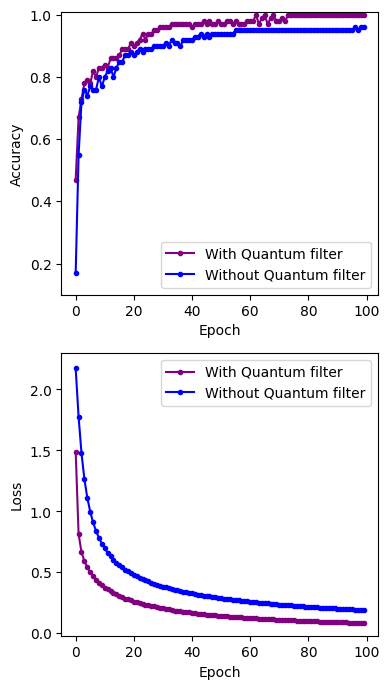

In [44]:
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 7))

ax1.plot(q_history.history["accuracy"], "-ob", label="With Quantum filter",marker='.', linestyle='-', color='purple')
ax1.plot(c_history.history["accuracy"], "-og", label="Without Quantum filter",marker='.', linestyle='-', color='blue')
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0.1, 1.01])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["loss"], "-ob", label="With Quantum filter",marker='.', linestyle='-', color='purple')
ax2.plot(c_history.history["loss"], "-og", label="Without Quantum filter",marker='.', linestyle='-', color='blue')
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.3)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In [3]:
# Pytorch
import torch, torchvision, torch.utils
from torch import Tensor
from torch import cat
from torch.autograd.grad_mode import no_grad
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss, BCELoss, CrossEntropyLoss, MSELoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
from torchviz import make_dot
from torchsummary import summary


# Qiskit
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
# from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap, ZFeatureMap
from qiskit.quantum_info import DensityMatrix, entanglement_of_formation
from qiskit.visualization import plot_state_city
# from qiskit_machine_learning.neural_networks import TwoLayerQNN
# 2023年12月1号 更新 https://github.com/qiskit-community/qiskit-machine-learning/releases
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [4]:
op_train_loaded = np.load('MNIST_op_train.npy')
op_test_loaded = np.load('MNIST_op_test.npy')

In [5]:
op_train_py = np.transpose(op_train_loaded, (0, 3, 1, 2))
print(op_train_py.shape)


(100, 4, 14, 14)


In [6]:
op_test_py = np.transpose(op_test_loaded, (0, 3, 1, 2))
print(op_test_py.shape)

(30, 4, 14, 14)


In [11]:
import torch

# 将op_train和op_test转换为PyTorch张量
op_train_tensor = torch.tensor(op_train_py)
op_test_tensor = torch.tensor(op_test_py)

# 创建包含图像张量和标签的元组
train_data = [(op_train_tensor[i], train_labels[i]) for i in range(len(op_train_tensor))]
test_data = [(op_test_tensor[i], test_labels[i]) for i in range(len(op_test_tensor))]

# 打印转换后的第一个元组，检查格式是否正确
print(train_data[0])


(tensor([[[ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -0.1412, -0.9369,
          -0.9997, -0.9993, -0.9993, -0.9993,  0.9852,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000, -0.9993, -0.9529,
          -0.0677, -0.0554, -0.9993, -0.9993,  0.7473,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           1.0000,  1.0000, -0.9891, -0.9993,  1.0000,  1.0000,  1.0000],
         [ 1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,  1.0000,
           0.4347, -0.9951, -0.9993, -0.8090

In [12]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=1)
test_loader = DataLoader(test_data, shuffle= True, batch_size=1)

In [13]:
for batch_idx, (data, target) in enumerate(train_loader):
    print("Batch Index:", batch_idx)
    print("Data Shape:", data.shape)
    print("Target Shape:", target.shape)

Batch Index: 0
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 1
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 2
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 3
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 4
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 5
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 6
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 7
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 8
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 9
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 10
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.Size([1])
Batch Index: 11
Data Shape: torch.Size([1, 4, 14, 14])
Target Shape: torch.

In [14]:
# === Step 1: 创建 QNN ===
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn

# === STEP 2: 定义模型结构 ===
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(4, 8, 3)
        self.conv2 = Conv2d(8, 16, 3)
        self.dropout = Dropout2d()
        self.fc2 = None
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        if self.fc2 is None:
            self.fc2 = Linear(x.shape[1], 2).to(x.device)
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return x

In [16]:
def train_qcq_cnn(train_loader, epochs=100, seed=42):
    # 设置种子，保证每次初始化不同（或可控）
    import numpy as np, random
    from torch.nn.utils import clip_grad_norm_

    start_time = time.time()  # 
    
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)

    # 重新创建模型和 optimizer
    qnn = create_qnn()
    model = Net(qnn).to('cuda')
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    loss_func = torch.nn.CrossEntropyLoss().to('cuda')

    loss_list, acc_list = [], []

    model.train()
    for epoch in range(epochs):
        correct = 0
        total_loss = []
        for data, target in train_loader:
            optimizer.zero_grad(set_to_none=True)
            output = model(data.to('cuda'))
            loss = loss_func(output, target.to('cuda').long())
            loss.backward()
            optimizer.step()
            total_loss.append(loss.item())
            pred = output.argmax(dim=1)
            correct += pred.eq(target.to('cuda')).sum().item()

        epoch_loss = sum(total_loss) / len(total_loss)
        epoch_acc = 100. * correct / len(train_loader)
        loss_list.append(epoch_loss)
        acc_list.append(epoch_acc)

        print(f"[{epoch+1:3d}/{epochs}] Loss: {epoch_loss:.4f} | Accuracy: {epoch_acc:.2f}%")

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"\n✅ Total training time: {elapsed_time:.2f} seconds")

    return model, loss_list, acc_list


In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix_percent(model, test_loader, class_names=["Class 0", "Class 1"]):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to('cuda'))
            preds = output.argmax(dim=1).cpu()
            all_preds.extend(preds.numpy())
            all_labels.extend(target.numpy())

    # 计算混淆矩阵（原始张数）
    cm = confusion_matrix(all_labels, all_preds)
    
    # 归一化为百分比（每一行是一个真实标签）
    cm_percent = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] * 100

    # 绘图
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.ylabel("True Label", fontsize=13)
    plt.xlabel("Predicted Label", fontsize=13)
    plt.title("Confusion Matrix (Percentage)", fontsize=14)
    plt.tight_layout()
    plt.show()


In [21]:
model1, loss1, acc1 = train_qcq_cnn(train_loader, epochs=100, seed=32)


[  1/100] Loss: 0.7258 | Accuracy: 51.00%
[  2/100] Loss: 0.7285 | Accuracy: 44.00%
[  3/100] Loss: 0.7134 | Accuracy: 49.00%
[  4/100] Loss: 0.6806 | Accuracy: 59.00%
[  5/100] Loss: 0.6675 | Accuracy: 62.00%
[  6/100] Loss: 0.6072 | Accuracy: 79.00%
[  7/100] Loss: 0.5957 | Accuracy: 81.00%
[  8/100] Loss: 0.6175 | Accuracy: 73.00%
[  9/100] Loss: 0.5943 | Accuracy: 78.00%
[ 10/100] Loss: 0.5642 | Accuracy: 80.00%
[ 11/100] Loss: 0.5166 | Accuracy: 85.00%
[ 12/100] Loss: 0.5018 | Accuracy: 84.00%
[ 13/100] Loss: 0.4918 | Accuracy: 85.00%
[ 14/100] Loss: 0.4775 | Accuracy: 84.00%
[ 15/100] Loss: 0.4539 | Accuracy: 88.00%
[ 16/100] Loss: 0.4626 | Accuracy: 84.00%
[ 17/100] Loss: 0.4162 | Accuracy: 87.00%
[ 18/100] Loss: 0.3850 | Accuracy: 91.00%
[ 19/100] Loss: 0.3758 | Accuracy: 91.00%
[ 20/100] Loss: 0.4089 | Accuracy: 85.00%
[ 21/100] Loss: 0.3468 | Accuracy: 88.00%
[ 22/100] Loss: 0.3303 | Accuracy: 91.00%
[ 23/100] Loss: 0.3380 | Accuracy: 92.00%
[ 24/100] Loss: 0.3242 | Accuracy:

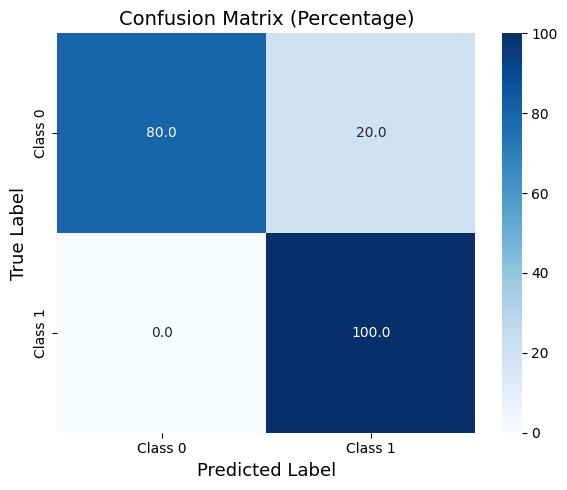

In [34]:
plot_confusion_matrix_percent(model1, test_loader)


In [23]:
print("Loss per epoch:")
for l in loss1:
    print(f"{l:.4f}")


Loss per epoch:
0.7258
0.7285
0.7134
0.6806
0.6675
0.6072
0.5957
0.6175
0.5943
0.5642
0.5166
0.5018
0.4918
0.4775
0.4539
0.4626
0.4162
0.3850
0.3758
0.4089
0.3468
0.3303
0.3380
0.3242
0.3181
0.3896
0.3210
0.3065
0.2954
0.2419
0.2685
0.2774
0.2671
0.2827
0.2545
0.2203
0.2170
0.2126
0.3122
0.1960
0.2395
0.2741
0.2246
0.2181
0.2298
0.1449
0.2310
0.1620
0.1940
0.2601
0.2307
0.1826
0.1602
0.2357
0.1901
0.1656
0.1666
0.1881
0.1783
0.1350
0.2539
0.1495
0.1336
0.1807
0.1559
0.1495
0.2118
0.1418
0.1618
0.1520
0.2063
0.1097
0.1435
0.1364
0.1315
0.1139
0.1448
0.1153
0.1024
0.1313
0.1233
0.1158
0.1496
0.1296
0.0888
0.2077
0.1212
0.1265
0.1088
0.0869
0.0999
0.1455
0.1321
0.1409
0.1185
0.1048
0.1536
0.1341
0.1127
0.1103


In [24]:
print("Accuracy per epoch:")
for a in acc1:
    print(f"{a/100:.4f}")


Accuracy per epoch:
0.5100
0.4400
0.4900
0.5900
0.6200
0.7900
0.8100
0.7300
0.7800
0.8000
0.8500
0.8400
0.8500
0.8400
0.8800
0.8400
0.8700
0.9100
0.9100
0.8500
0.8800
0.9100
0.9200
0.8900
0.9200
0.8400
0.8900
0.9200
0.9100
0.9600
0.9100
0.9200
0.8900
0.9000
0.9200
0.9500
0.9300
0.9200
0.8800
0.9500
0.9300
0.9200
0.9400
0.9200
0.9100
0.9800
0.9300
0.9600
0.9400
0.9000
0.9200
0.9700
0.9700
0.9000
0.9400
0.9500
0.9600
0.9500
0.9300
0.9700
0.8900
0.9600
0.9800
0.9500
0.9600
0.9500
0.9200
0.9600
0.9400
0.9500
0.9400
0.9800
0.9600
0.9500
0.9800
0.9600
0.9500
0.9800
0.9700
0.9700
0.9600
0.9700
0.9300
0.9600
0.9900
0.9200
0.9500
0.9500
0.9800
0.9700
0.9800
0.9300
0.9600
0.9600
0.9600
0.9600
0.9600
0.9500
0.9800
0.9700


In [25]:
# === 多次运行训练，并收集每次的 loss 数据 ===
import pandas as pd

results = []

for seed in [32, 42, 52, 62, 72]:  # 多个种子
    model, loss_list, acc_list = train_qcq_cnn(train_loader, epochs=100, seed=seed)
    for epoch, loss in enumerate(loss_list):
        results.append({
            'Seed': seed,
            'Epoch': epoch + 1,
            'Loss': loss,
            'Dataset': 'MNIST'  # ← 可以标注你当前是哪个数据集
        })

df = pd.DataFrame(results)
df.to_excel("qcqcnn_loss_MNIST.xlsx", index=False)

[  1/100] Loss: 0.7258 | Accuracy: 51.00%
[  2/100] Loss: 0.7285 | Accuracy: 44.00%
[  3/100] Loss: 0.7134 | Accuracy: 49.00%
[  4/100] Loss: 0.6806 | Accuracy: 59.00%
[  5/100] Loss: 0.6675 | Accuracy: 62.00%
[  6/100] Loss: 0.6072 | Accuracy: 79.00%
[  7/100] Loss: 0.5957 | Accuracy: 81.00%
[  8/100] Loss: 0.6175 | Accuracy: 73.00%
[  9/100] Loss: 0.5943 | Accuracy: 78.00%
[ 10/100] Loss: 0.5642 | Accuracy: 80.00%
[ 11/100] Loss: 0.5166 | Accuracy: 85.00%
[ 12/100] Loss: 0.5018 | Accuracy: 84.00%
[ 13/100] Loss: 0.4918 | Accuracy: 85.00%
[ 14/100] Loss: 0.4775 | Accuracy: 84.00%
[ 15/100] Loss: 0.4539 | Accuracy: 88.00%
[ 16/100] Loss: 0.4626 | Accuracy: 84.00%
[ 17/100] Loss: 0.4162 | Accuracy: 87.00%
[ 18/100] Loss: 0.3850 | Accuracy: 91.00%
[ 19/100] Loss: 0.3758 | Accuracy: 91.00%
[ 20/100] Loss: 0.4089 | Accuracy: 85.00%
[ 21/100] Loss: 0.3468 | Accuracy: 88.00%
[ 22/100] Loss: 0.3303 | Accuracy: 91.00%
[ 23/100] Loss: 0.3380 | Accuracy: 92.00%
[ 24/100] Loss: 0.3242 | Accuracy:

   Seed  Epoch      Loss Dataset
0    32      1  0.725771   MNIST
1    32      2  0.728498   MNIST
2    32      3  0.713376   MNIST
3    32      4  0.680558   MNIST
4    32      5  0.667541   MNIST


/tmp/ipykernel_3291950/2544380194.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x="Seed", y="Loss", data=df, inner="quartile", palette="Set2")


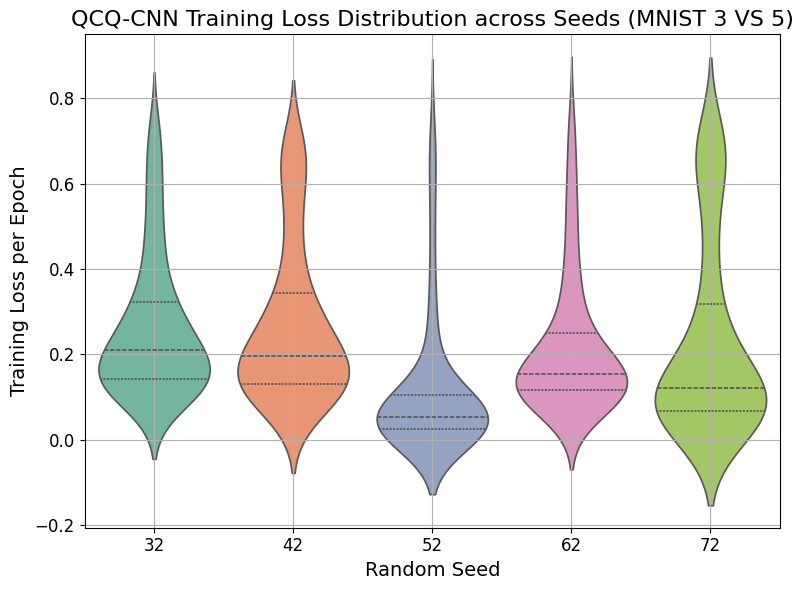

<Figure size 640x480 with 0 Axes>

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取你保存的 Excel 文件
df = pd.read_excel("qcqcnn_loss_MNIST.xlsx")

# 检查数据结构（可选）
print(df.head())

# 绘制小提琴图
plt.figure(figsize=(8, 6))
sns.violinplot(x="Seed", y="Loss", data=df, inner="quartile", palette="Set2")

plt.title("QCQ-CNN Training Loss Distribution across Seeds (MNIST 3 VS 5)", fontsize=16)
plt.xlabel("Random Seed", fontsize=14)
plt.ylabel("Training Loss per Epoch", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()
plt.savefig("violinplot_loss_qcqcnn.png", dpi=500)
